# Exploring LDA Visualizations

In [1]:
import os
from pprint import pprint
import pickle
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
from gensim import corpora, models
import seaborn as sns
from wordcloud import WordCloud
import colorcet as cc

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%watermark --iso8601 -u -v -m -iv 

Last updated: 2024-03-06T14:17:41.885015-05:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.16.1

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.0.3
gensim    : 4.3.2
colorcet  : 3.0.1
seaborn   : 0.13.2
matplotlib: 3.8.2



<br>

## Data Acquisition

In [3]:
# Path for the final split csv file
file_path: str = "/Users/nitingupta/Desktop/OTB/final_splits_Nov3.csv"

In [4]:
df: pd.DataFrame = pd.read_csv(file_path, index_col = 0, usecols=['id', 'sentence'])

# Get the years
df['year']: pd.Series = df.index.str.split("_").str[0]
df.set_index('year', inplace=True)
df.reset_index(inplace=True)

print(f"Number of rows in the DataFrame: {df.shape[0]:,}")

Number of rows in the DataFrame: 403,481


In [5]:
df.head()

year                                           sentence
0  1868-69  AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...
1  1868-69  Whereas, by an Act of Congress, approved the t...
2  1868-69  Beit enacted by the Senate and House of Repres...
3  1868-69  Upon the passage of this Act, the Governor of ...
4  1868-69  In the Senate House, the twentysecond day of J...

<br>

## Pre Processing
Most of the preprocessing done below is explained in `LDA.ipynb`.

In [6]:
# Read the cleaned sentences file
with open('checkpoint/cleaned_sentences.pkl', 'rb') as in_file:
    cleaned_sents: List[List[str]] = pickle.load(in_file)

In [7]:
# Create a dictionary: a mapping between words and their integer ids
dictionary = corpora.Dictionary(cleaned_sents)

# Filter extremes
dictionary.filter_extremes(no_below=10, no_above=1, keep_n=None)
print(f"Length of the dictionary after filtering: {len(dictionary):,}")

# Convert document into the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in cleaned_sents]

Length of the dictionary after filtering: 17,034


In [8]:
# Path for the LDA model
model_path: str = os.path.join('checkpoint', 'topic_model.lda')

# Load the LDA model

num_topics: int = 9
alpha: float = 0.1
eta: float = 0.001

# lda_model = models.ldamodel.LdaModel.load(model_path)

lda_model = models.ldamulticore.LdaMulticore(corpus=corpus,
                                             id2word=dictionary,
                                             num_topics=num_topics,
                                             alpha=alpha,
                                             eta=eta,
                                             per_word_topics=True)

In [9]:
# Get the 2 most significant topics.
# Show in word-probability pairs.
for topic in lda_model.show_topics(formatted=False)[:2]:
    pprint(topic)

(0,
 [('district', 0.06088382),
  ('school', 0.059892997),
  ('election', 0.020343201),
  ('trustee', 0.018287044),
  ('term', 0.017272959),
  ('member', 0.014483186),
  ('year', 0.012896721),
  ('education', 0.012859384),
  ('public', 0.009511759),
  ('office', 0.009096384)])
(1,
 [('court', 0.02144576),
  ('item', 0.020200877),
  ('service', 0.014203314),
  ('total', 0.012152926),
  ('supply', 0.0119771),
  ('equipment', 0.011167856),
  ('department', 0.0101908585),
  ('health', 0.008563466),
  ('dollar', 0.008172753),
  ('office', 0.0071193515)])


In [10]:
# Open a text file in write mode
with open("checkpoint/lda_topics.txt", "w") as file:
    # Show in word-probability pairs.
    for topic_idx, topic in lda_model.show_topics(formatted=False):
        # Write the topic index to the file
        file.write(f"Topic {topic_idx}:\n")
        # Write each word-probability pair to the file
        for word, prob in topic:
            file.write(f"{word}: {prob}\n")
        # Write a separator between topics
        file.write("\n")

<br>

## Visualizations

### Stack Plot for Topic Distribution over Time

In [11]:
# Get the topic distribution for each document as a list of (topic_id, topic_probability) 2-tuples.
document_topics = [lda_model.get_document_topics(doc) for doc in corpus]
print(f"Number of topics (matches the number of documents, i.e. rows): {len(document_topics):,}")

Number of topics (matches the number of documents, i.e. rows): 403,481


In [12]:
# Extracting the dominant topic for each document
dominant_topics: List[int] = [max(topics, key=lambda x: x[1])[0] for topics in document_topics]

In [13]:
# Add the dominant topic information back to the DataFrame
df['dominant_topic'] = dominant_topics

In [14]:
df.head()

year                                           sentence  dominant_topic
0  1868-69  AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...               4
1  1868-69  Whereas, by an Act of Congress, approved the t...               4
2  1868-69  Beit enacted by the Senate and House of Repres...               4
3  1868-69  Upon the passage of this Act, the Governor of ...               7
4  1868-69  In the Senate House, the twentysecond day of J...               5

In [15]:
# Group documents by year and calculate the average topic distribution for each year
    # Calculate the normalized counts of the dominant topics for each year using value_counts(normalize=True).
    # Reshape the resulting DataFrame to have the years as rows and the dominant topics as columns using unstack().
topic_distribution_by_year = df.groupby('year')['dominant_topic'].value_counts(normalize=True).unstack()

# Fill missing values with 0 (if there are years with no documents)
topic_distribution_by_year = topic_distribution_by_year.fillna(0)

# Print the aggregated topic distributions by year
display(topic_distribution_by_year)

dominant_topic         0         1         2         3         4         5  \
year                                                                         
1868-69         0.086447  0.171429  0.083516  0.167033  0.047619  0.178022   
1869-1870       0.146853  0.066933  0.167832  0.192807  0.086913  0.156843   
1870-1871       0.147709  0.051343  0.157188  0.098736  0.065561  0.285150   
1871            0.083104  0.073931  0.226197  0.139057  0.080352  0.229499   
1871-1872       0.088109  0.073066  0.239971  0.144699  0.078080  0.209885   
...                  ...       ...       ...       ...       ...       ...   
1964            0.144179  0.186137  0.038256  0.120938  0.092966  0.145413   
1965            0.121945  0.171270  0.035295  0.159446  0.062825  0.108356   
1966            0.183394  0.132117  0.045985  0.123358  0.077372  0.143066   
1967            0.141202  0.094539  0.236845  0.095532  0.067733  0.134363   
1968            0.169208  0.164873  0.110463  0.117190  0.066966  0.132735   

dominant_topic         6         7         8  
year                                          
1868-69         0.018315  0.149451  0.098168  
1869-1870       0.040959  0.073926  0.066933  
1870-1871       0.045814  0.082938  0.065561  
1871            0.047698  0.065676  0.054485  
1871-1872       0.051576  0.067335  0.047278  
...                  ...       ...       ...  
1964            0.126697  0.067051  0.078363  
1965            0.080473  0.108797  0.151593  
1966            0.142701  0.068796  0.083212  
1967            0.113293  0.061004  0.055488  
1968            0.118984  0.062332  0.057250  

[100 rows x 9 columns]

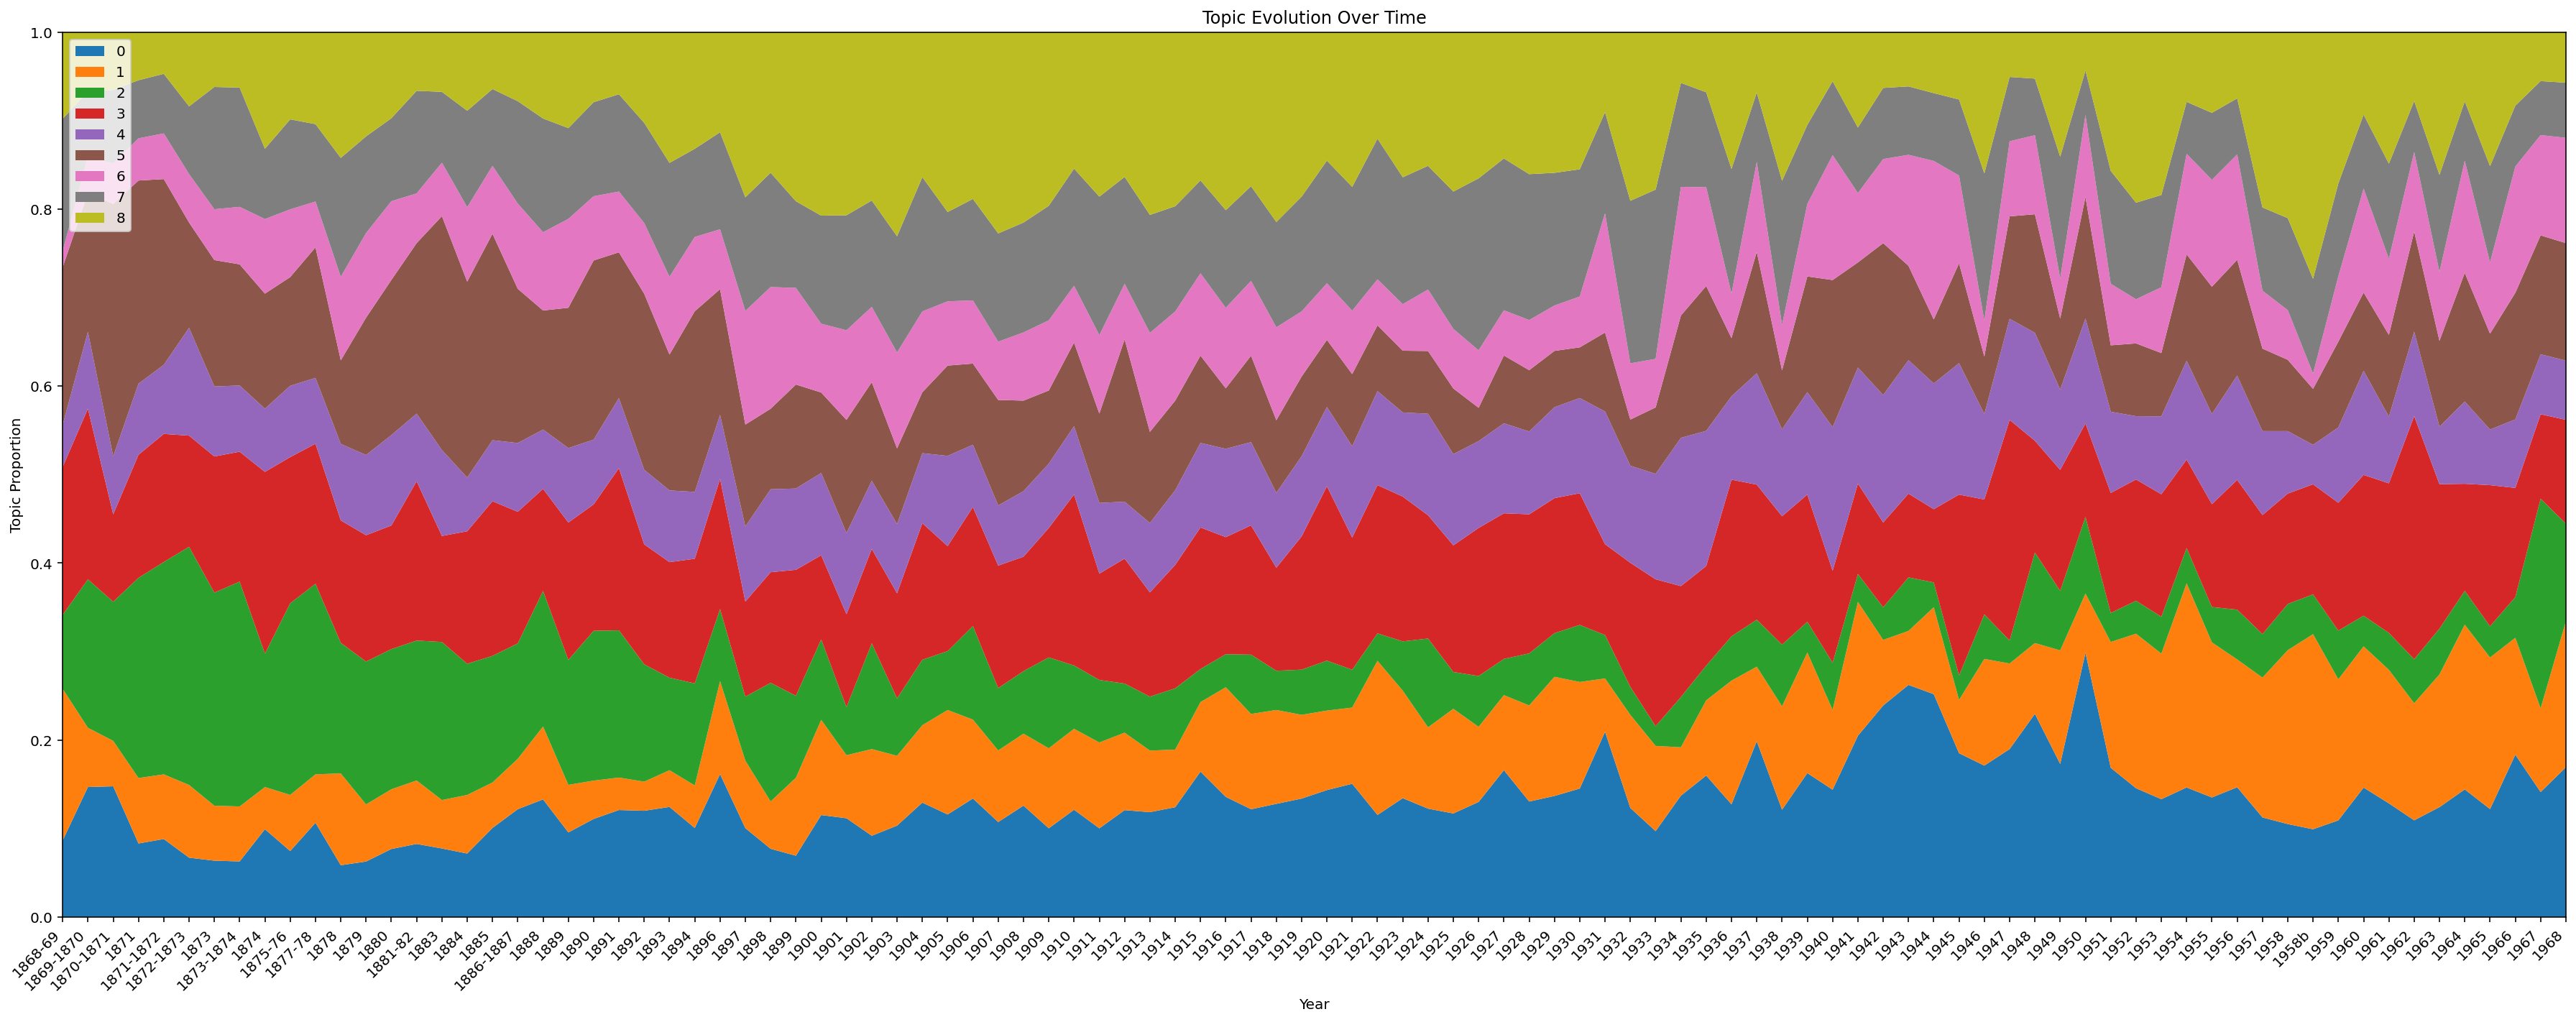

In [16]:
# Plotting the stacked area chart for topic evolution over time
plt.figure(figsize=(25, 10))

# Plotting each topic as a stacked area
# Pass the years as the x-values and the topic proportions for each year as the y-values.
plt.stackplot(topic_distribution_by_year.index, 
              topic_distribution_by_year.values.T, 
              labels=topic_distribution_by_year.columns)

plt.title('Topic Evolution Over Time')

plt.xlabel('Year')
plt.xticks(rotation=45, ha='right')
plt.margins(x=0)
plt.margins(y=0)
plt.ylabel('Topic Proportion')

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('imgs/topic_evolution.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

In [17]:
# Extracting the decade from the 'year' column
df['decade'] = df['year'].astype(str).str[:3] + '0s'
df.head()

year                                           sentence  dominant_topic  \
0  1868-69  AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...               4   
1  1868-69  Whereas, by an Act of Congress, approved the t...               4   
2  1868-69  Beit enacted by the Senate and House of Repres...               4   
3  1868-69  Upon the passage of this Act, the Governor of ...               7   
4  1868-69  In the Senate House, the twentysecond day of J...               5   

  decade  
0  1860s  
1  1860s  
2  1860s  
3  1860s  
4  1860s

In [18]:
# Group documents by decade and calculate the average topic distribution for each decade
topic_distribution_by_decade = df.groupby('decade')['dominant_topic'].value_counts(normalize=True).unstack()

# Fill missing values with 0 (if there are decades with no documents)
topic_distribution_by_decade = topic_distribution_by_decade.fillna(0)

# Print the aggregated topic distributions by decade
display(topic_distribution_by_year)

dominant_topic         0         1         2         3         4         5  \
year                                                                         
1868-69         0.086447  0.171429  0.083516  0.167033  0.047619  0.178022   
1869-1870       0.146853  0.066933  0.167832  0.192807  0.086913  0.156843   
1870-1871       0.147709  0.051343  0.157188  0.098736  0.065561  0.285150   
1871            0.083104  0.073931  0.226197  0.139057  0.080352  0.229499   
1871-1872       0.088109  0.073066  0.239971  0.144699  0.078080  0.209885   
...                  ...       ...       ...       ...       ...       ...   
1964            0.144179  0.186137  0.038256  0.120938  0.092966  0.145413   
1965            0.121945  0.171270  0.035295  0.159446  0.062825  0.108356   
1966            0.183394  0.132117  0.045985  0.123358  0.077372  0.143066   
1967            0.141202  0.094539  0.236845  0.095532  0.067733  0.134363   
1968            0.169208  0.164873  0.110463  0.117190  0.066966  0.132735   

dominant_topic         6         7         8  
year                                          
1868-69         0.018315  0.149451  0.098168  
1869-1870       0.040959  0.073926  0.066933  
1870-1871       0.045814  0.082938  0.065561  
1871            0.047698  0.065676  0.054485  
1871-1872       0.051576  0.067335  0.047278  
...                  ...       ...       ...  
1964            0.126697  0.067051  0.078363  
1965            0.080473  0.108797  0.151593  
1966            0.142701  0.068796  0.083212  
1967            0.113293  0.061004  0.055488  
1968            0.118984  0.062332  0.057250  

[100 rows x 9 columns]

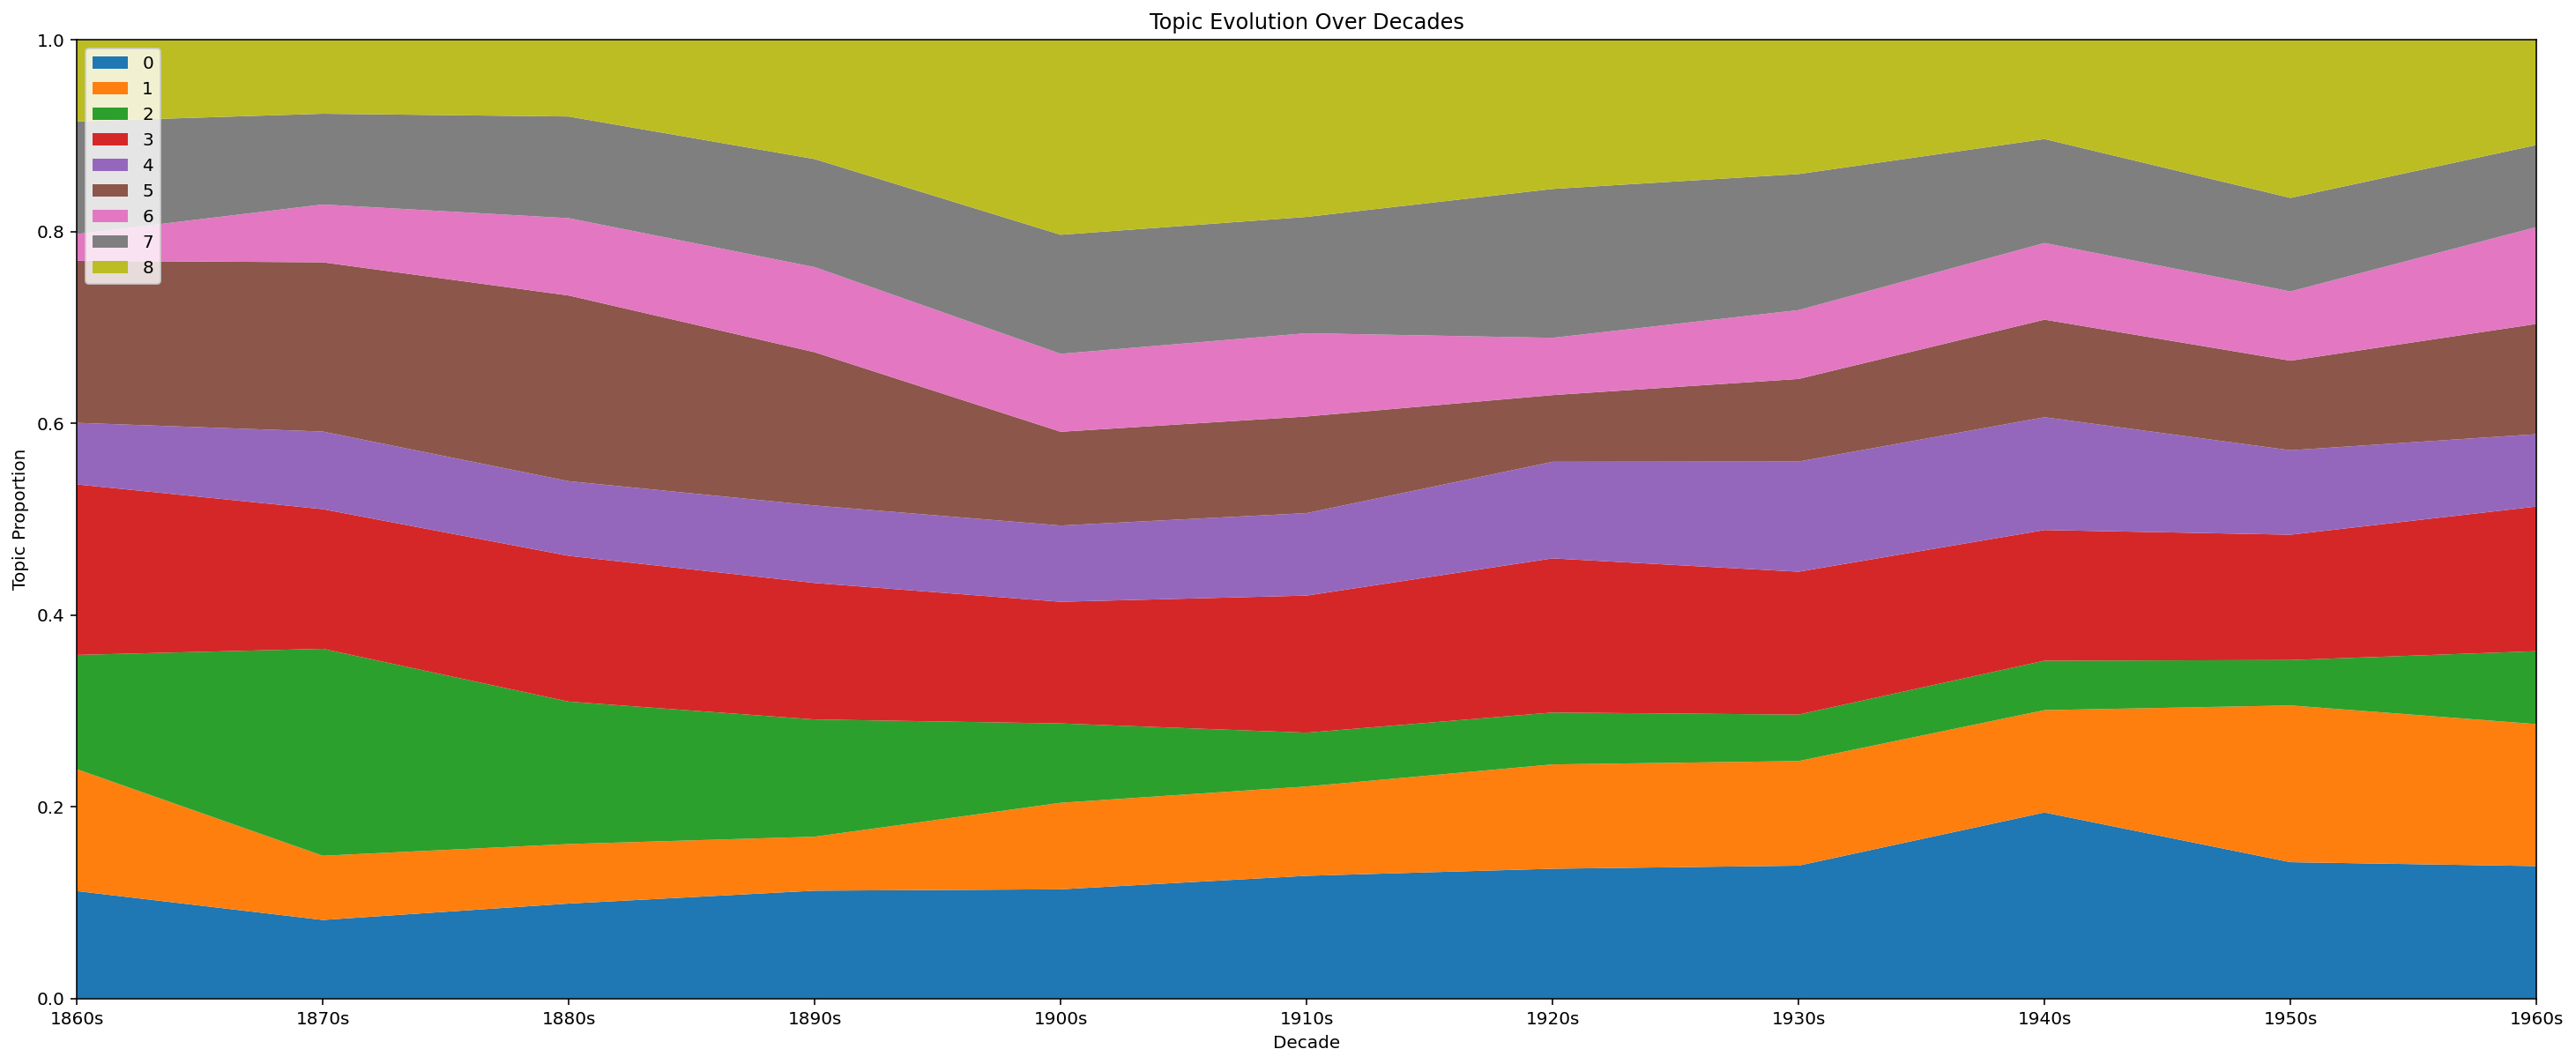

In [19]:
# Plotting the stacked area chart for topic evolution over decades
plt.figure(figsize=(25, 10))

# Plotting each topic as a stacked area
plt.stackplot(topic_distribution_by_decade.index, topic_distribution_by_decade.values.T, labels=topic_distribution_by_decade.columns)

plt.title('Topic Evolution Over Decades')

plt.xlabel('Decade')
plt.margins(x=0)
plt.margins(y=0)
plt.ylabel('Topic Proportion')

plt.legend(loc='upper left')
# plt.tight_layout()
plt.savefig('imgs/topic_evolution_decade.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

<br>

## Topic Distribution by Jim Crow

In [20]:
df1: pd.DataFrame = pd.read_csv('data/PredLabels_corpus.csv', index_col = 0, usecols=['id', 'sentence', 'predicted_label'])

# Get the years
df1['year']: pd.Series = df1.index.str.split("_").str[0]
df1.set_index('year', inplace=True)
df1.reset_index(inplace=True)

print(f"Number of rows in the DataFrame: {df1.shape[0]:,}")

Number of rows in the DataFrame: 403,481


In [21]:
df1

year                                           sentence  \
0       1868-69  AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...   
1       1868-69  Whereas, by an Act of Congress, approved the t...   
2       1868-69  Beit enacted by the Senate and House of Repres...   
3       1868-69  Upon the passage of this Act, the Governor of ...   
4       1868-69  In the Senate House, the twentysecond day of J...   
...         ...                                                ...   
403476     1968                          Buy and sell real estate.   
403477     1968  63.1 of the 1962 Code, relating to the purchas...   
403478     1968  The board is authorized to buy any real estate...   
403479     1968  The board is further authorized to sell any re...   
403480     1968  No purchase or sale shall be made unless the w...   

        predicted_label  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
403476                0  
403477                0  
403478                0  
403479                0  
403480                0  

[403481 rows x 3 columns]

In [22]:
df1.predicted_label.value_counts()

predicted_label
0    397300
1      5244
2       937
Name: count, dtype: int64

In [23]:
# Check if the two dataframes are equal, ignoring NaN values
if df[['year', 'sentence']].equals(df1[['year', 'sentence']]):
    print("All rows match.")
else:
    print("Rows do not match.")

All rows match.


In [24]:
# Append the predicted_label column to `df`, which contains the dominant_topic
df2 = pd.concat([df, df1['predicted_label']], axis=1)
df2

year                                           sentence  \
0       1868-69  AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...   
1       1868-69  Whereas, by an Act of Congress, approved the t...   
2       1868-69  Beit enacted by the Senate and House of Repres...   
3       1868-69  Upon the passage of this Act, the Governor of ...   
4       1868-69  In the Senate House, the twentysecond day of J...   
...         ...                                                ...   
403476     1968                          Buy and sell real estate.   
403477     1968  63.1 of the 1962 Code, relating to the purchas...   
403478     1968  The board is authorized to buy any real estate...   
403479     1968  The board is further authorized to sell any re...   
403480     1968  No purchase or sale shall be made unless the w...   

        dominant_topic decade  predicted_label  
0                    4  1860s                0  
1                    4  1860s                0  
2                    4  1860s                0  
3                    7  1860s                0  
4                    5  1860s                0  
...                ...    ...              ...  
403476               2  1960s                0  
403477               6  1960s                0  
403478               7  1960s                0  
403479               7  1960s                0  
403480               4  1960s                0  

[403481 rows x 5 columns]

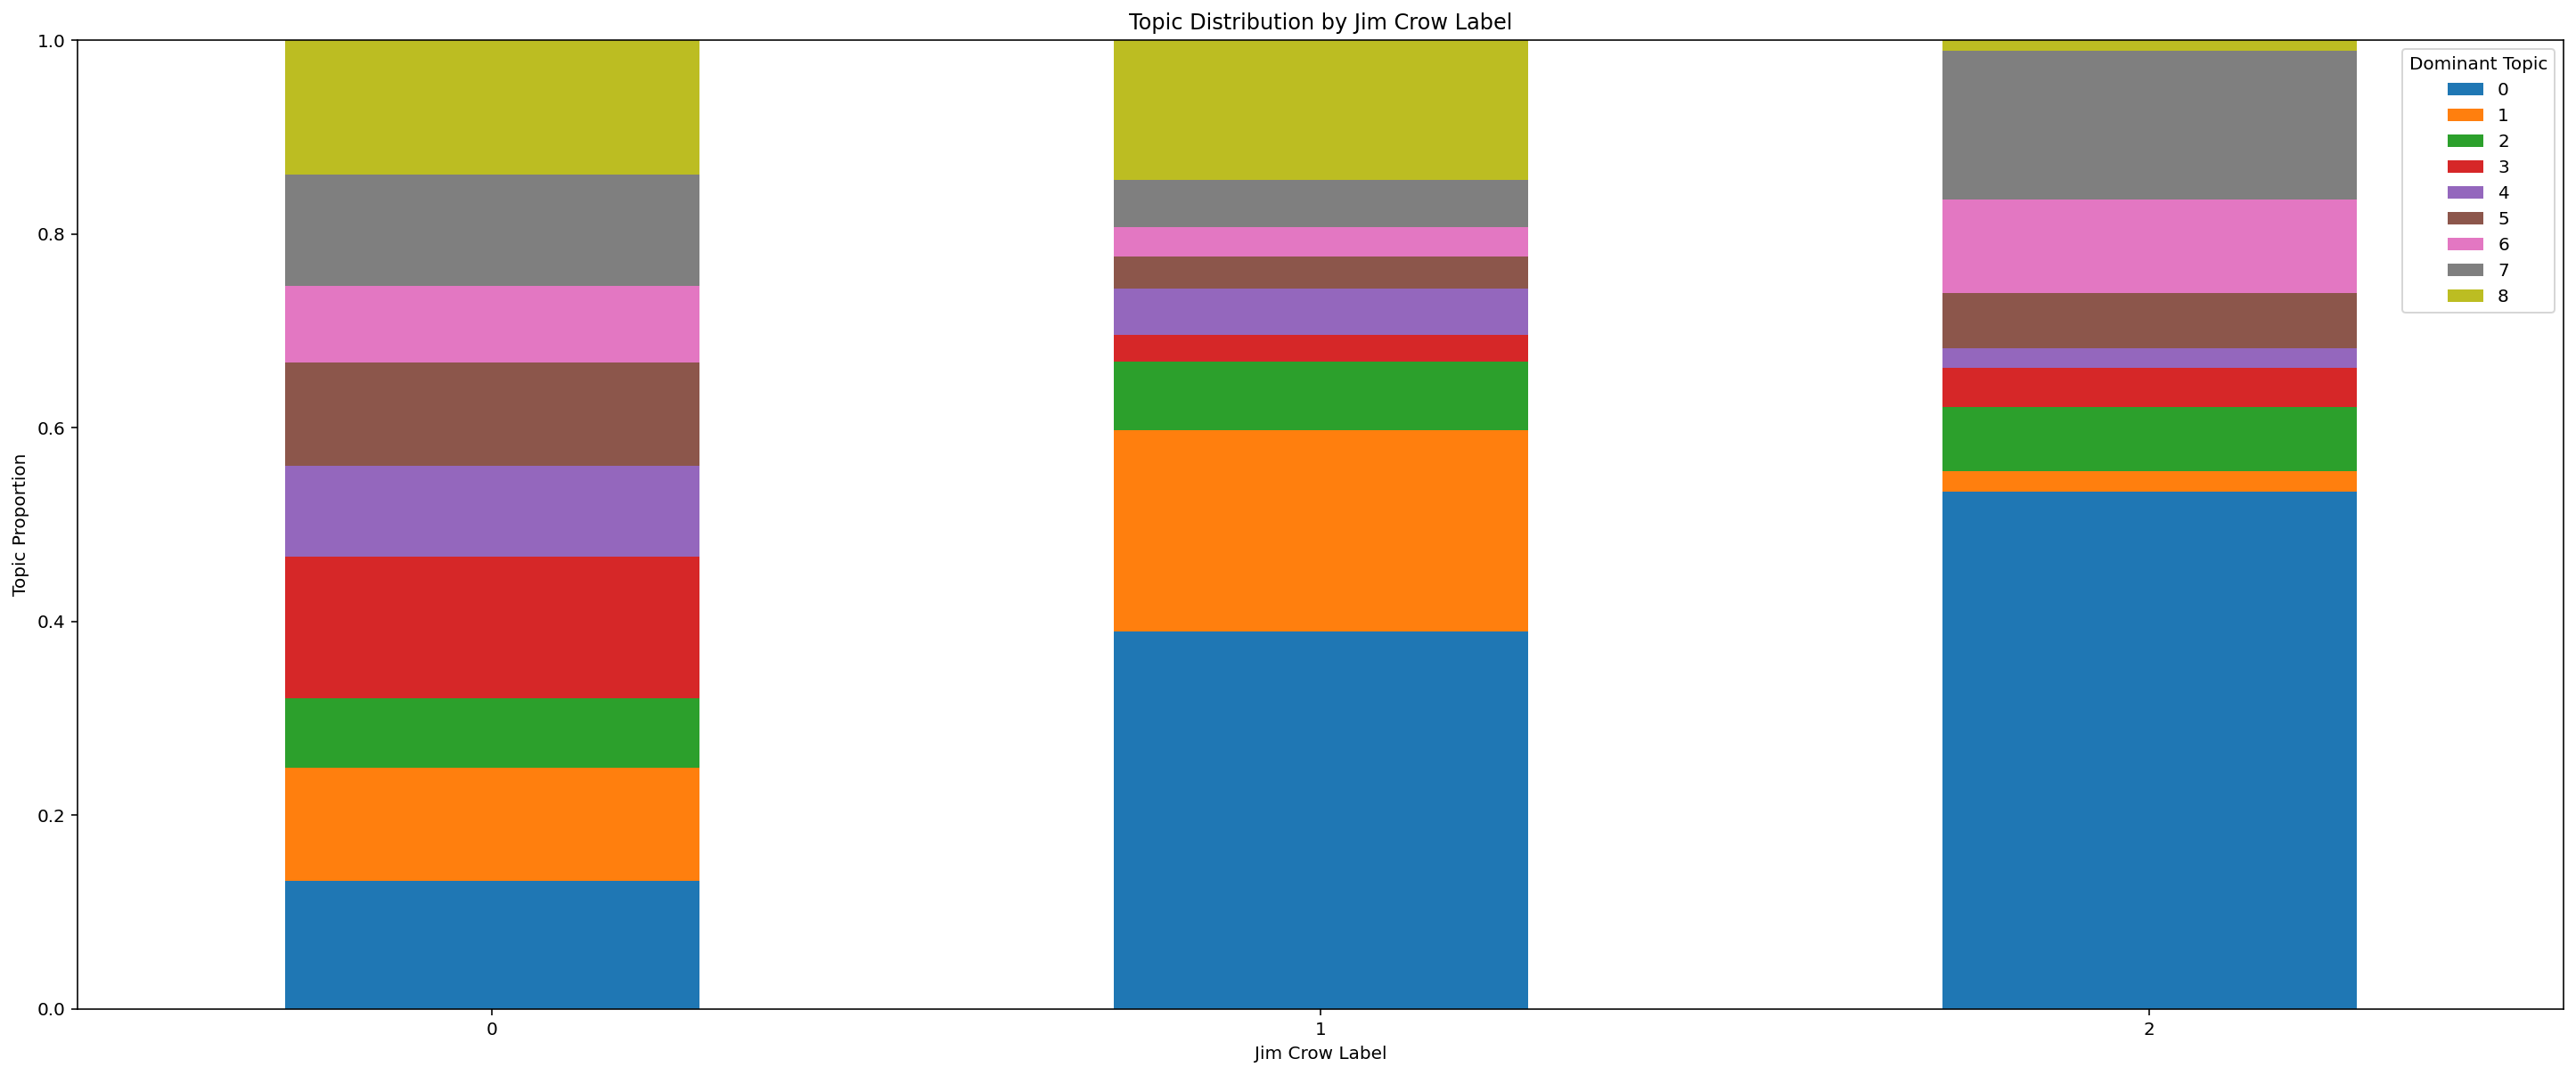

In [25]:
# Group the data by the Jim Crow label and the 'dominant_topic' column
topic_distribution_by_label = df2.groupby(['predicted_label', 'dominant_topic']).size().unstack(fill_value=0)

# Normalize the counts within each label category to get proportions
topic_distribution_by_label_normalized = topic_distribution_by_label.div(topic_distribution_by_label.sum(axis=1), axis=0)

# Plotting the topic distribution by Jim Crow label
plt.figure(figsize=(25, 10))

# Plotting a stacked bar chart
topic_distribution_by_label_normalized.plot(kind='bar', stacked=True, ax=plt.gca())

plt.title('Topic Distribution by Jim Crow Label')

plt.xlabel('Jim Crow Label')
plt.ylabel('Topic Proportion')
plt.margins(x=0)
plt.margins(y=0)

plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.legend(title='Dominant Topic')

plt.savefig('imgs/topic_dist_jc.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

<br>

### Topic Co-occurrence with Jim Crow Language
A heatmap to show the co-occurrence of topics with Jim Crow language labels to help identify topics that frequently co-occur with Jim Crow language and uncover potential themes or associations.

Each cell represents the proportion of sentences associated with a specific topic and Jim Crow label category. Darker cells indicate higher proportions, while lighter cells indicate lower proportions. The clustering of rows and columns helps identify patterns and associations between topics and Jim Crow language labels.

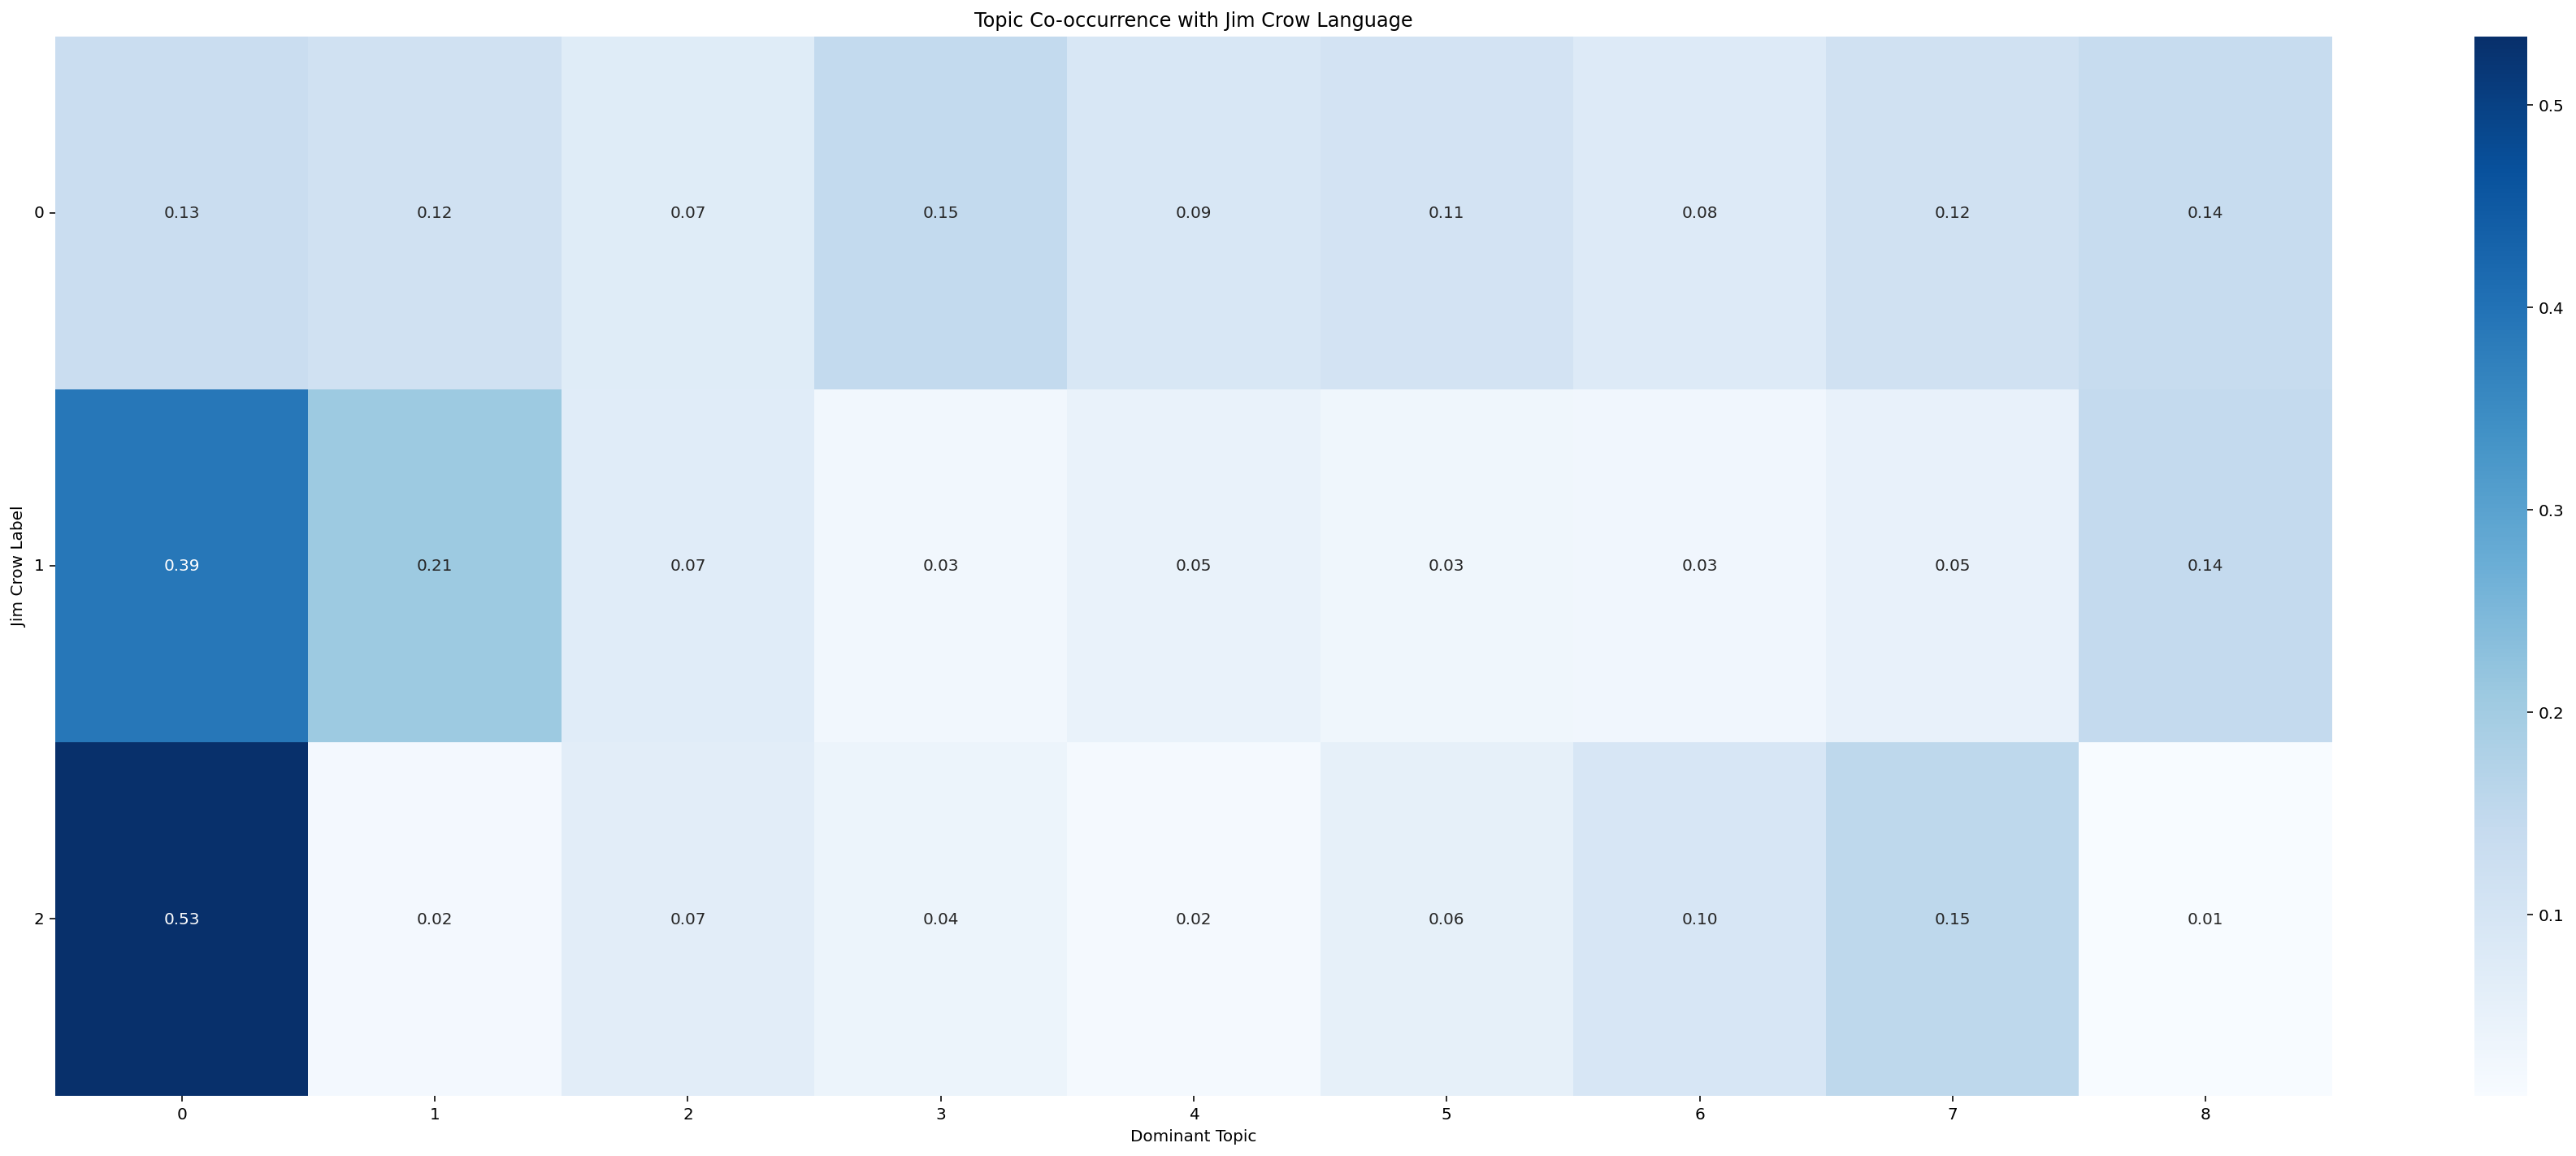

In [26]:
# Group the data by the Jim Crow label and the 'dominant_topic' column
# Count the occurrences of each topic within each label category and reshape the data into a DataFrame using unstack()
topic_distribution_by_label = df2.groupby(['predicted_label', 'dominant_topic']).size().unstack(fill_value=0)

# Normalize the counts within each label category to get proportions
topic_distribution_by_label_normalized = topic_distribution_by_label.div(topic_distribution_by_label.sum(axis=1), axis=0)

# Plotting the heatmap for topic co-occurrence with Jim Crow language
plt.figure(figsize=(25, 10))

# Plotting a clustered heatmap
sns.heatmap(topic_distribution_by_label_normalized, cmap='Blues', annot=True, fmt='.2f')

plt.title('Topic Co-occurrence with Jim Crow Language')
plt.xlabel('Dominant Topic')
plt.ylabel('Jim Crow Label')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig('imgs/topic-co-jc.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

<br>

## Jim Crow Language Proportion Over Time
- The values on the y-axis indicate the proportion of sentences that contain Jim Crow language relative to the total number of sentences for each year.
- For example, if the y-axis value is 0.2 (or 20%), it means that 20% of the sentences from that particular year contain Jim Crow language.
- A higher value on the y-axis indicates a higher proportion of sentences containing Jim Crow language, while a lower value indicates a lower proportion.
- By tracking the changes in the y-axis values over time, you can observe how the prevalence of Jim Crow language in the dataset fluctuates across different years.

In [27]:
# Extract only the numeric part from the 'year' column
df2['year_trunc'] = df2['year'].str.extract('(\d+)')

# Convert the 'year' column to numeric data
df2['year_trunc'] = pd.to_numeric(df2['year_trunc'])

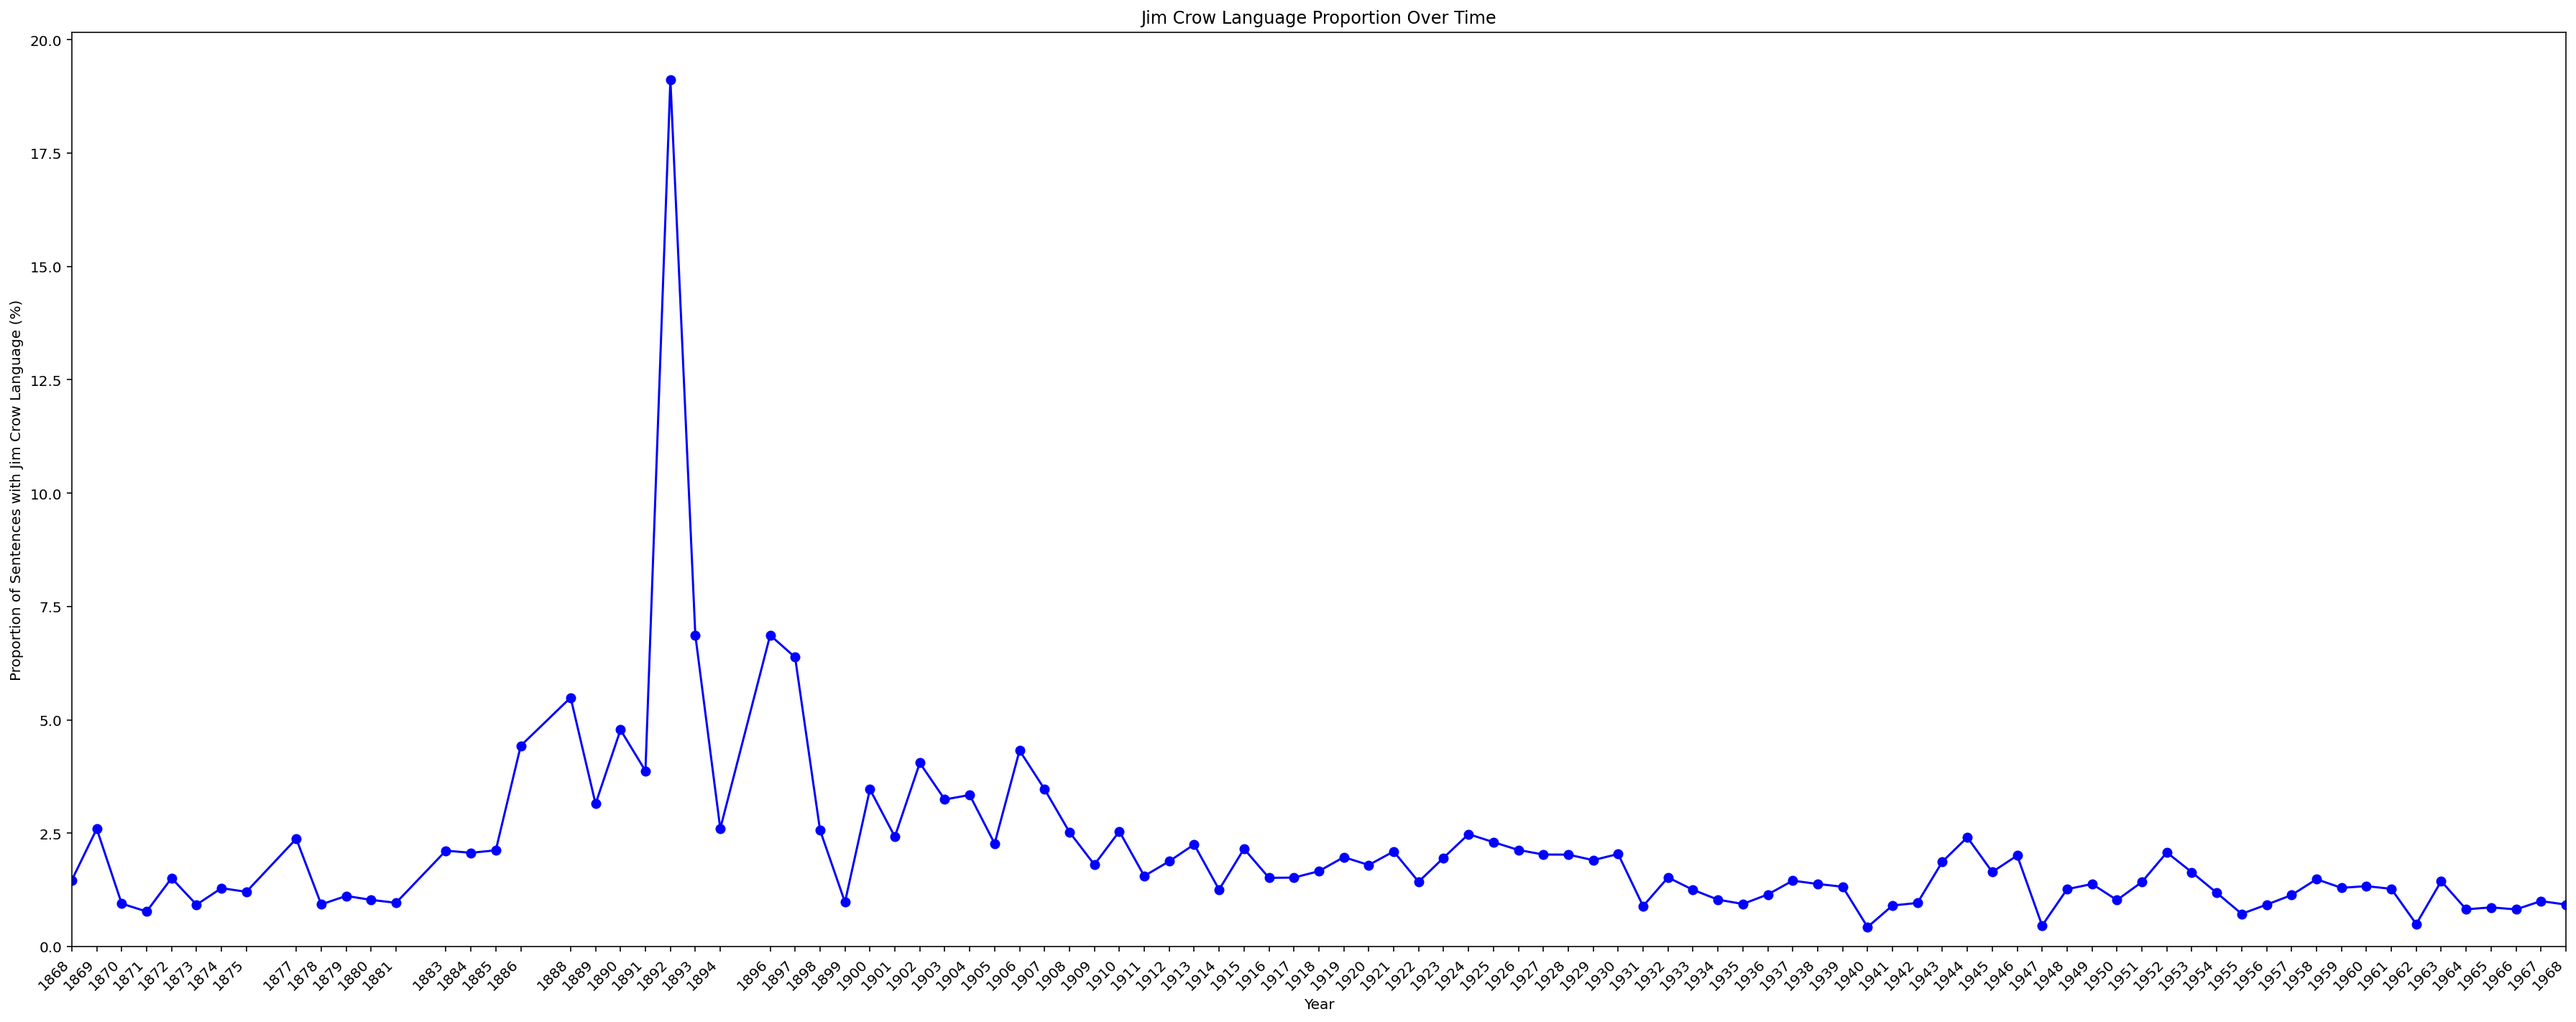

In [28]:
# Group the data by year and calculate the proportion of sentences containing Jim Crow language
# Multiply by 100 to convert to percentage
jim_crow_proportion_by_year = df2.groupby('year_trunc')['predicted_label'].mean() * 100

# Plotting the proportion of sentences containing Jim Crow language over time
plt.figure(figsize=(25, 10))

# Plotting a line chart
jim_crow_proportion_by_year.plot(kind='line', marker='o', color='b', linestyle='-')

plt.title('Jim Crow Language Proportion Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Sentences with Jim Crow Language (%)')

plt.margins(x=0)
plt.margins(y=0)
plt.ylim(0, jim_crow_proportion_by_year.max() * 1.055)

plt.xticks(jim_crow_proportion_by_year.index, rotation=45, ha='right')  # Set the tick positions and labels

# plt.grid(True)
plt.tight_layout()
plt.savefig('imgs/topic_dist_jc.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

<br>

### Word Clouds for Jim Crow Language

In [29]:
jim_crow_sentences = df2[df2['predicted_label'] == 1]['sentence'].str.cat(sep=' ')

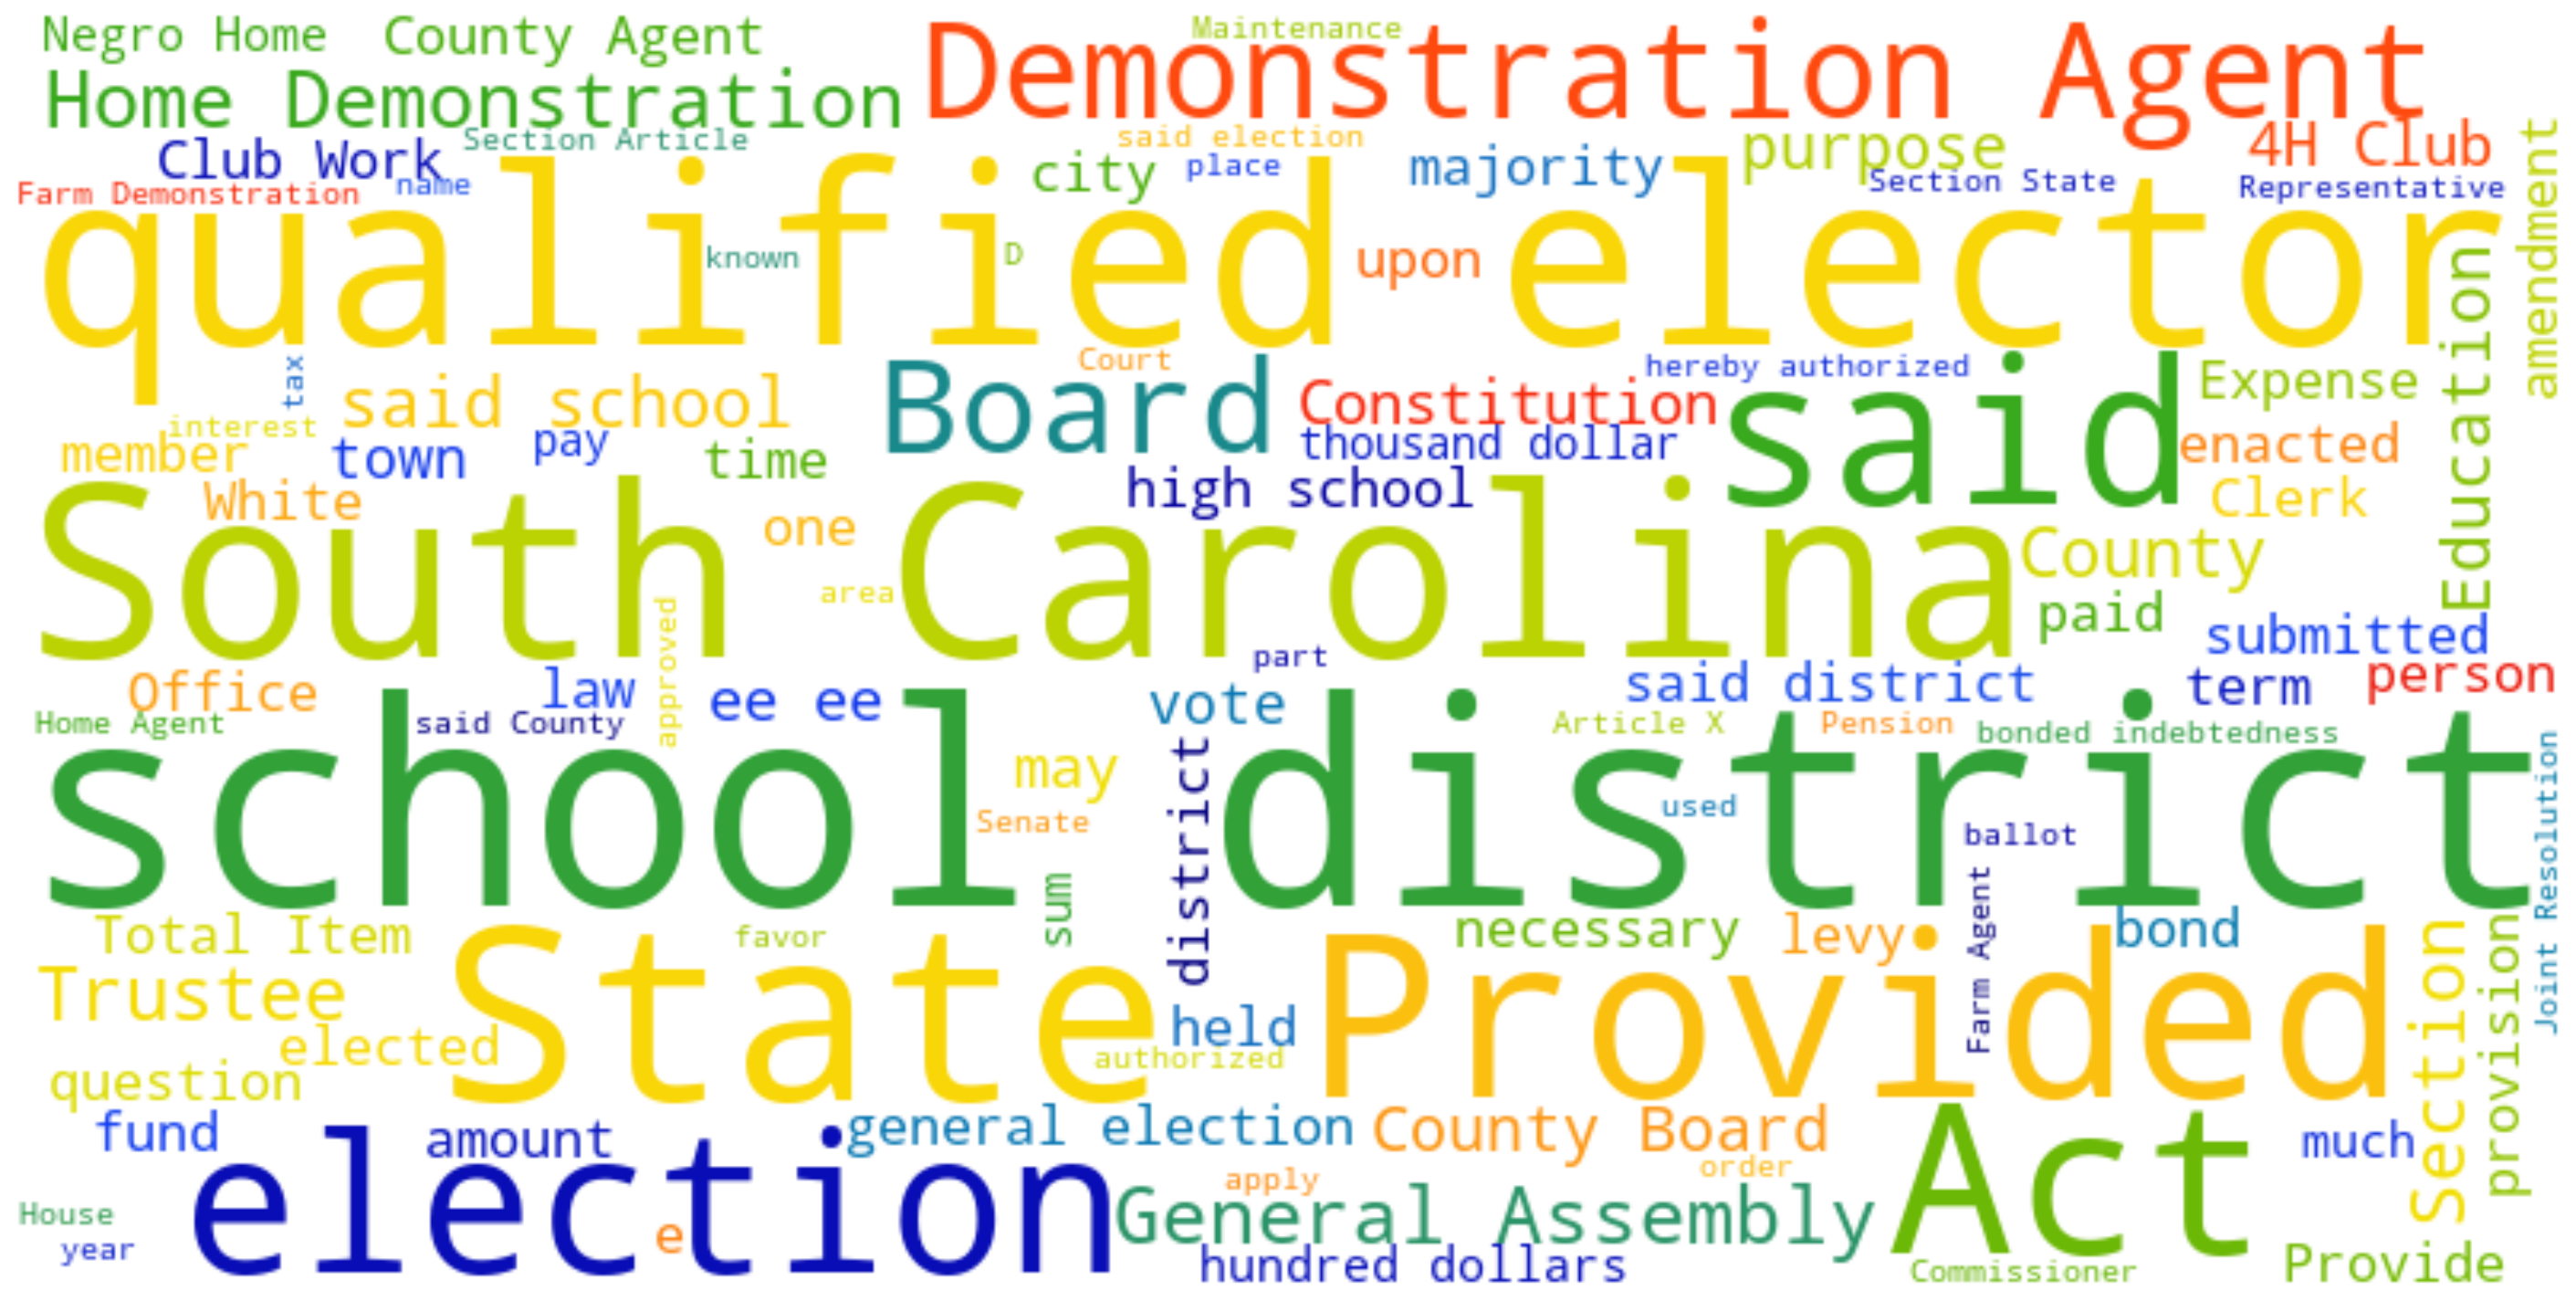

In [30]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=cc.m_rainbow4,
                      max_font_size=100, min_font_size=10, max_words=100).generate(jim_crow_sentences)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
# plt.title('Word Cloud for Jim Crow Language')
plt.axis('off')
plt.tight_layout()

plt.savefig('imgs/word-cloud-jc.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

<br>

### Word Clouds for Topics

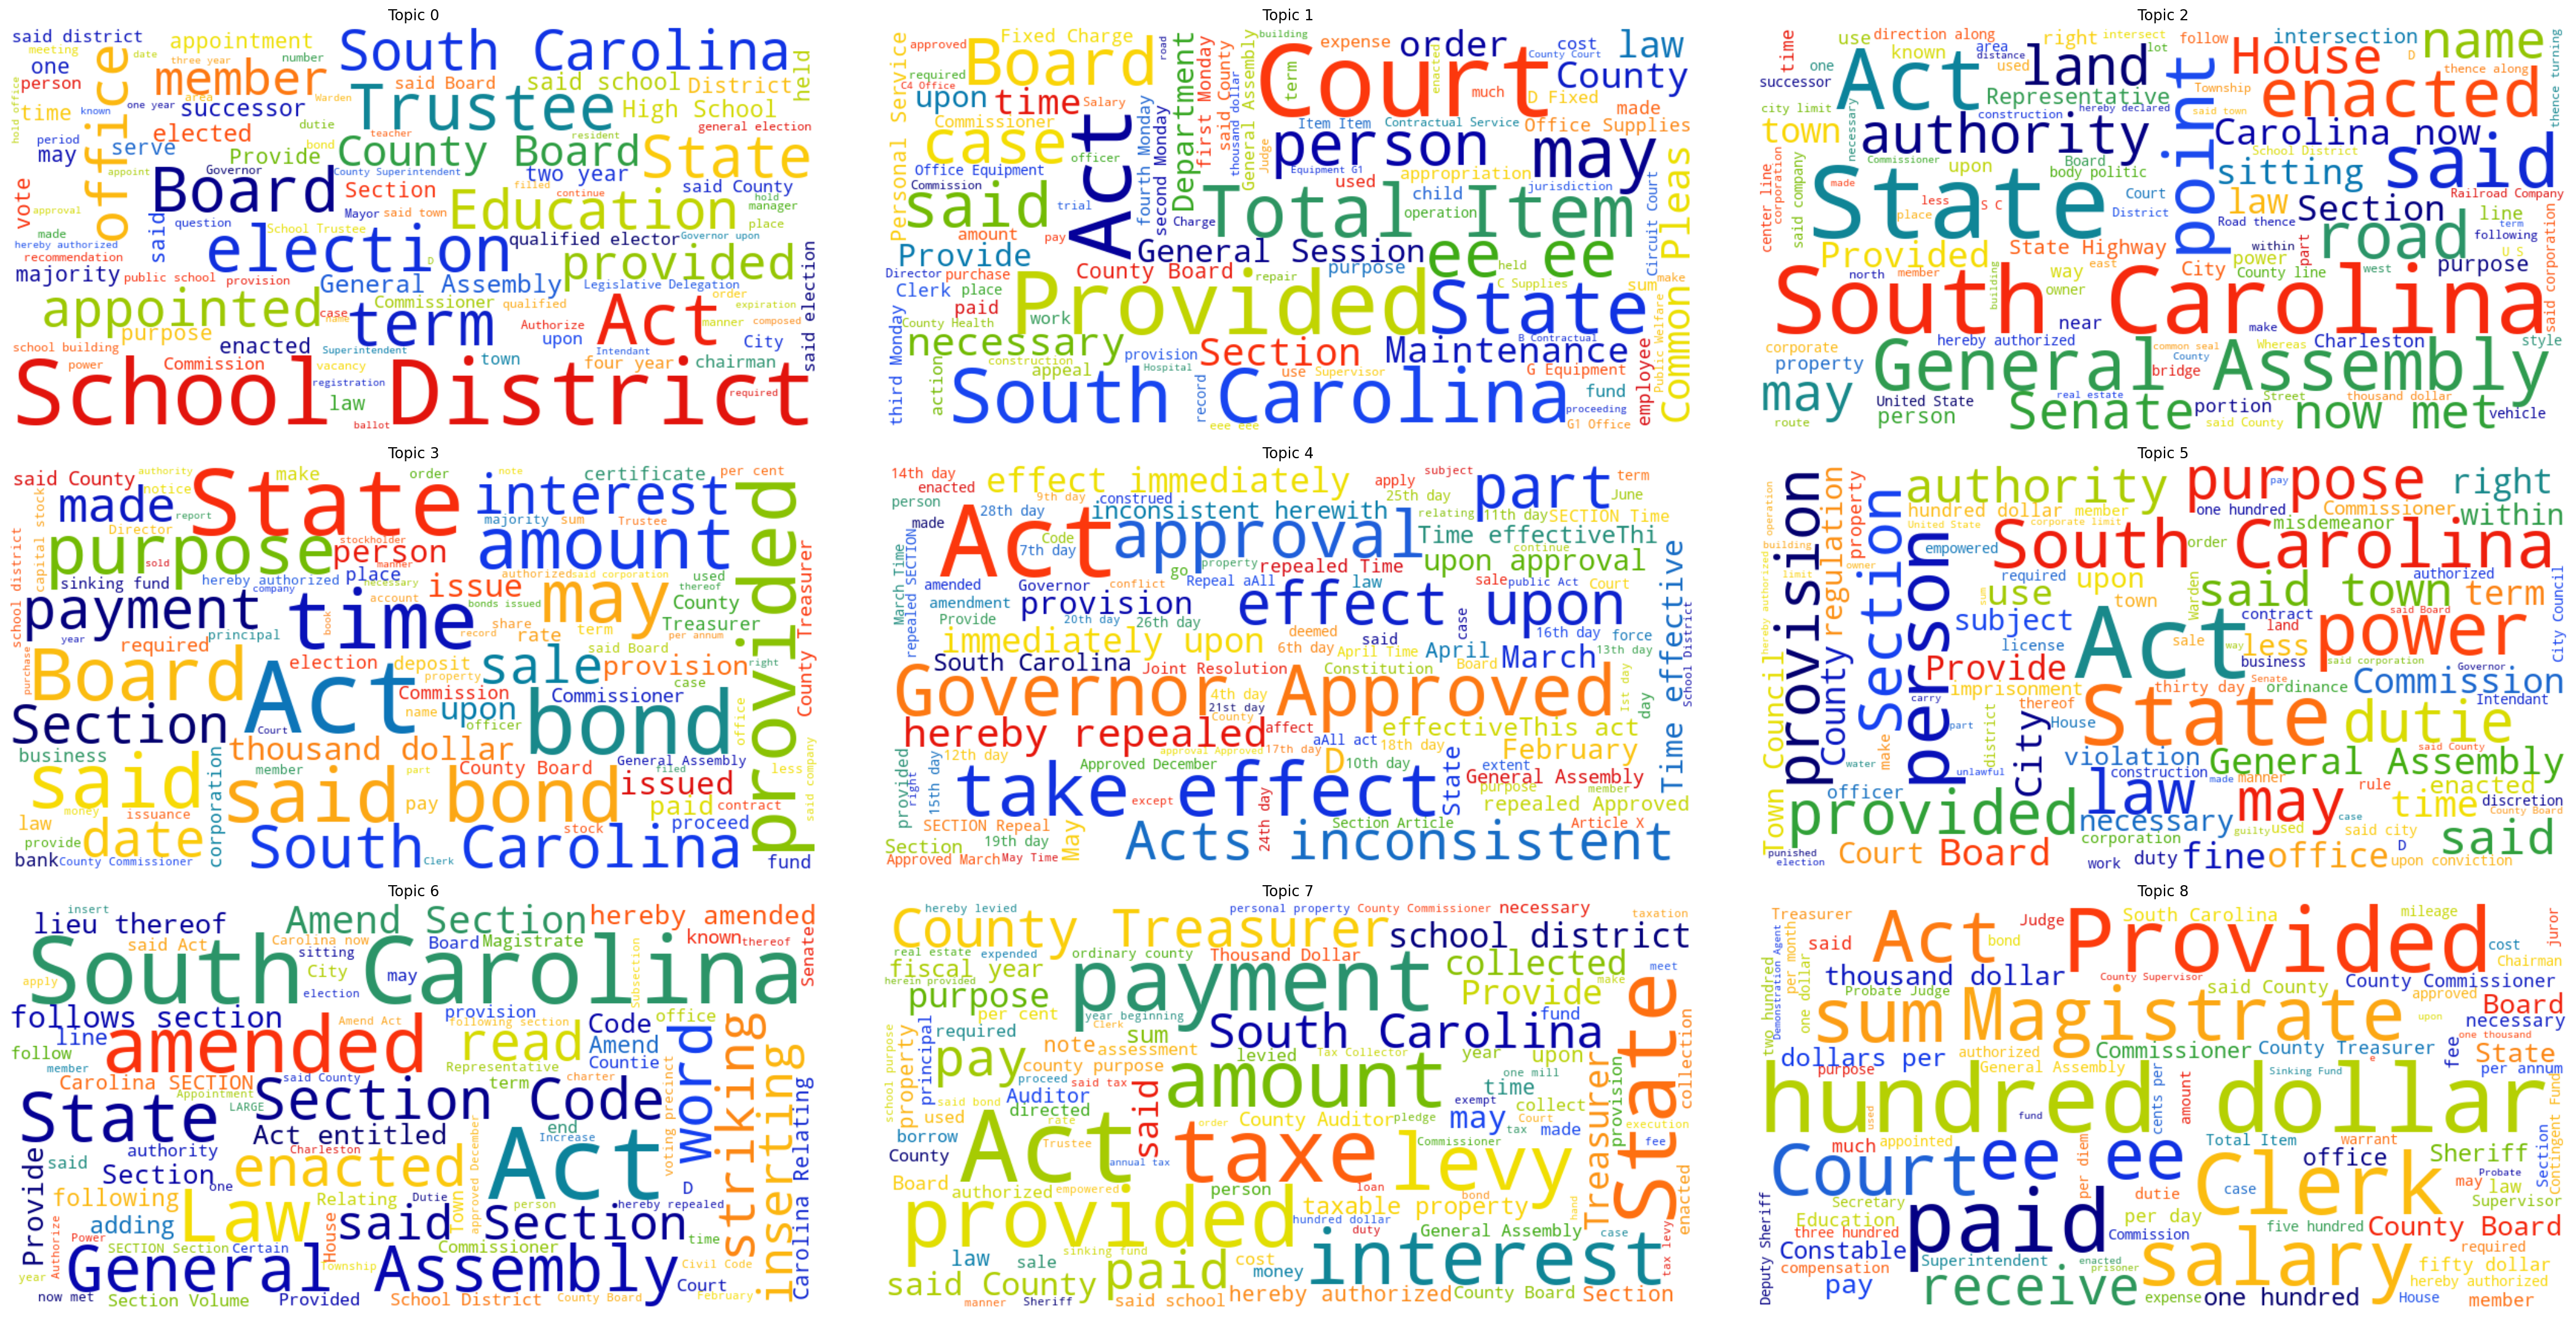

In [31]:
# Create a figure and axes for subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))

# Iterate over topics and create a word cloud for each topic
for topic_id in range(num_topics):
    # Filter sentences for the current topic
    topic_sentences = df2[df2['dominant_topic'] == topic_id]['sentence'].str.cat(sep=' ')
    
    # Generate word cloud for the current topic
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=cc.m_rainbow4,
                          max_font_size=100, min_font_size=10, max_words=100).generate(topic_sentences)
    
    # Plot the word cloud in the corresponding subplot
    ax = axs[topic_id // 3, topic_id % 3]  # Calculate the row and column index for the current topic
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Topic {topic_id}')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig('imgs/word-cloud-topics.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()